In [1]:
from typing import Dict, List

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from dataandcoords import set_data_and_coords
from gpapproximation import make_gp_basis, sample_all
from posteriorplots import predictive_plot, retrodictive_plot
from zerosumnormal import ZeroSumNormal

if pm.math.erf.__module__.split(".")[0] == "theano":
    import theano.tensor as aet
else:
    import aesara.tensor as aet

In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
TEST_CUTOFF = pd.Timedelta(8, "W")
(polls_train, polls_test, results, PARTIES_COMPLETE) = set_data_and_coords(TEST_CUTOFF)
_, UNIQUE_ELECTIONS = polls_train["dateelection"].factorize()
_, UNIQUE_POLLSTERS = polls_train["sondage"].factorize()

/Users/alex_andorra/repos/pollsposition/models/presidential-elections/dataandcoords.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["countdown"] = dates_to_idx(df["date"], date).astype(int)


In [5]:
polls_train

date     sondage dateelection  countdown  samplesize  farleft  left  \
0   2002-01-02         BVA   2002-04-21        109         919       64   221   
1   2002-01-03         CSA   2002-04-21        108         997       50   214   
2   2002-01-04       Ipsos   2002-04-21        107        5297      318  1218   
3   2002-01-05         BVA   2002-04-21        106         500       35   120   
4   2002-01-05      Kantar   2002-04-21        106         763       53   183   
..         ...         ...          ...        ...         ...      ...   ...   
341 2017-02-23       Odoxa   2017-04-23         59         884      106   115   
342 2017-02-24      Kantar   2017-04-23         58         700       70    98   
343 2017-02-25        Ifop   2017-04-23         57        1200      138   162   
344 2017-02-25  OpinionWay   2017-04-23         57        1038      114   156   
345 2017-02-26        Ifop   2017-04-23         56        1192      137   167   

     green  center  right  farright  other  
0       64      46    193        92    239  
1       60      40    279       100    254  
2      265     212   1483       477   1324  
3       35      15    135        45    115  
4       46      23    206        69    183  
..     ...     ...    ...       ...    ...  
341      0     221    168       239     35  
342      0     175    140       189     28  
343      0     294    240       312     54  
344      0     249    218       270     31  
345      0     286    244       304     54  

[346 rows x 12 columns]

### Add predictors

#### Election results for sample size

In [6]:
# need number of people who voted
raw_json = pd.read_json(
    "https://raw.githubusercontent.com/pollsposition/data/main/resultats/presidentielles.json",
)
raw_json = raw_json.loc["premier_tour"].to_dict()

In [7]:
jsons = []
for year, dateelection in zip(
    results.dateelection.dt.year.unique(), results.dateelection.unique()
):
    df = pd.json_normalize(raw_json[year])[["exprimes"]]
    df["dateelection"] = dateelection
    jsons.append(df)
jsons = pd.concat(jsons)

In [8]:
results_mult = (
    results.join(jsons.set_index("dateelection"), on="dateelection")
    .drop("samplesize", axis="columns")
    .rename(columns={"exprimes": "samplesize"})
)
results_mult["samplesize"] = (
    results_mult["samplesize"] // 100
)  # to prevent overflow in Multinomial

In [9]:
results_mult[PARTIES_COMPLETE] = (
    (results_mult[PARTIES_COMPLETE] / 100)
    .mul(results_mult["samplesize"], axis=0)
    .round()
    .fillna(0)
    .astype(int)
)
results_mult["samplesize"] = results_mult[PARTIES_COMPLETE].sum(1)

In [10]:
results_mult

dateelection       date  countdown sondage  farleft    left  green  \
74    2002-04-21 2002-04-21          0  result    16301   46110  14962   
141   2007-04-22 2007-04-22          0  result    19865   94993   5765   
294   2012-04-22 2012-04-22          0  result    39830  102734   8289   
439   2017-04-23 2017-04-23          0  result    70594   22931      0   

     center   right  farright  other  samplesize  
74    19493   56655     48048  83415      284984  
141   68188  114491     38335  25557      367194  
294   32761   97531     64231  13456      358832  
439   86566   72145     76796  31511      360543

#### Unemployment

In [11]:
unemp = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/predicteurs/chomage_national_trim.csv",
    sep=";",
    skiprows=2,
).iloc[:, [0, 1]]
unemp.columns = ["date", "unemployment"]
unemp = unemp.sort_values("date")

# as timestamps variables:
unemp.index = pd.period_range(start=unemp.date.iloc[0], periods=len(unemp), freq="Q")
unemp = unemp.drop("date", axis=1)

In [12]:
# add quarters to polls data
polls_train.index = pd.DatetimeIndex(polls_train["date"].values).to_period("Q")
polls_test.index = pd.DatetimeIndex(polls_test["date"].values).to_period("Q")
results_mult.index = pd.DatetimeIndex(results_mult["date"].values).to_period("Q")

In [13]:
# merge with unemployment:
polls_train = polls_train.join(unemp).reset_index(drop=True)
polls_test = polls_test.join(unemp).reset_index(drop=True)
results_mult = results_mult.join(unemp).reset_index(drop=True)

#### Presidential popularity

In [14]:
popularity = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/dashboards/main/exports/popularity_all_presidents.csv",
    parse_dates=["month"],
)
popularity["month"] = popularity["month"].dt.to_period("M")
popularity = popularity.set_index("month")
popularity.index = popularity.index.shift(-1)

In [15]:
raw_popularity = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/sondages/popularite.csv",
    index_col=0,
)
raw_popularity = raw_popularity[raw_popularity.president == "chirac1"]
raw_popularity.index = pd.to_datetime(raw_popularity.index)

raw_popularity = raw_popularity.resample("M").mean()
raw_popularity.index = raw_popularity.index.to_period("M")

raw_popularity["president"] = "chirac1"
raw_popularity["mean_pop"] = raw_popularity["approve_pr"] / 100
raw_popularity = raw_popularity.drop(
    ["samplesize", "approve_pr", "disapprove_pr"], axis="columns"
)

In [16]:
popularity = pd.concat([raw_popularity, popularity])

In [17]:
polls_train.index = polls_train["date"].dt.to_period("M")
polls_train = polls_train.join(popularity).reset_index(drop=True)

polls_test.index = polls_test["date"].dt.to_period("M")
polls_test = polls_test.join(popularity).reset_index(drop=True)

results_mult.index = results_mult["date"].dt.to_period("M")
results_mult = results_mult.join(popularity).reset_index(drop=True)

#### Standardize continous predictors

In [18]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [19]:
cont_preds = (
    pd.concat(
        [
            polls_train[["date", "unemployment", "mean_pop"]],
            results_mult[["date", "unemployment", "mean_pop"]],
        ]
    )
    .set_index("date")
    .sort_index()
)
cont_preds_stdz = standardize(cont_preds)

In [20]:
results_preds = cont_preds_stdz.loc[UNIQUE_ELECTIONS]
campaign_preds = cont_preds_stdz.loc[cont_preds.index.difference(UNIQUE_ELECTIONS)]
results_oos = results_mult[results_mult.dateelection != "2017-04-23"].copy()

## Model with socio-eco predictors

- https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/
-    Jobs, as indicated by nonfarm payrolls.
    Spending, as indicated by real personal consumption expenditures.
    Income, as measured by real disposable personal income.
    Manufacturing, as measured by industrial production.
    Inflation, based on the consumer price index.9
    And the stock market, based on the S&P 500.

In [ ]:
# https://github.com/indigo-ag/biods-lab/pull/325/files
# https://nbviewer.org/github/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb

In [127]:
def dims_and_coords(
    data: pd.DataFrame,
    parties_complete: List[str],
):
    COORDS = {
        "observations": data.index,
        "parties": parties_complete[:-1],
        "parties_complete": parties_complete,
    }
    pollster_id, COORDS["pollsters"] = data["sondage"].factorize(sort=True)
    countdown_id, COORDS["countdown"] = data["countdown"].values, np.arange(
        data["countdown"].max() + 1
    )
    election_id, COORDS["elections"] = data["dateelection"].factorize()

    return pollster_id, countdown_id, election_id, COORDS


def model_factory(
    data_dict: Dict[str, pd.DataFrame],
    parties_complete: List[str],
):
    GP_CONFIG = {
        "lengthscale": [5, 14, 28],
        "kernel": "gaussian",
        "zerosum": True,
        "variance_limit": 0.95,
        "variance_weight": [0.1, 0.3, 0.6],
    }
    polls_train, campaign_preds, results_oos, results_preds = (
        data_dict["polls_train"],
        data_dict["campaign_preds"],
        data_dict["results_oos"],
        data_dict["results_preds"],
    )
    pollster_id, countdown_id, election_id, COORDS = dims_and_coords(
        polls_train, parties_complete
    )

    with pm.Model(coords=COORDS) as model:
        election_idx = pm.Data("election_idx", election_id, dims="observations")
        pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
        countdown_idx = pm.Data("countdown_idx", countdown_id, dims="observations")
        stdz_unemp = pm.Data(
            "stdz_unemp",
            campaign_preds["unemployment"].to_numpy(),
            dims="observations",
        )
        stdz_pop = pm.Data(
            "stdz_pop",
            campaign_preds["mean_pop"].to_numpy(),
            dims="observations",
        )
        election_unemp = pm.Data(
            "election_unemp",
            results_preds["unemployment"].to_numpy(),
            dims="elections",
        )
        election_pop = pm.Data(
            "election_pop",
            results_preds["mean_pop"].to_numpy(),
            dims="elections",
        )
        observed_N = pm.Data(
            "observed_N", polls_train["samplesize"].to_numpy(), dims="observations"
        )
        observed_polls = pm.Data(
            "observed_polls",
            polls_train[COORDS["parties_complete"]].to_numpy(),
            dims=("observations", "parties_complete"),
        )
        results_N = pm.Data(
            "results_N",
            results_oos["samplesize"].to_numpy(),
        )  # dims="elections - 1"
        observed_results = pm.Data(
            "observed_results",
            results_oos[COORDS["parties_complete"]].to_numpy(),
            # dims=("elections -1 ", "parties_complete"),
        )

        party_intercept = ZeroSumNormal(
            "party_intercept", sigma=0.5, dims="parties_complete"
        )
        election_party_intercept_sd = pm.HalfNormal(
            "election_party_intercept_sd", 0.15, dims="parties_complete"
        )
        election_party_intercept = ZeroSumNormal(
            "election_party_intercept",
            sigma=election_party_intercept_sd[None, ...],
            dims=("elections", "parties_complete"),
            zerosum_axes=(0, 1),
        )

        house_effects = ZeroSumNormal( # try with pm.Normal
            "house_effects",
            sigma=0.1,
            dims=("pollsters", "parties_complete"),
            zerosum_axes=(0, 1), # try no ZeroSum on pollsters
        )
        house_election_effect_sd = pm.HalfNormal(
            "house_election_effect_sd", 0.15, dims=("pollsters", "parties_complete")
        )
        house_election_effects_raw = ZeroSumNormal(
            "house_election_effects_raw",
            dims=("pollsters", "parties_complete", "elections"),
            zerosum_axes=(0, 1, 2),
        )
        house_election_effects = pm.Deterministic(
            "house_election_effects",
            house_election_effect_sd[..., None] * house_election_effects_raw,
            dims=("pollsters", "parties_complete", "elections"),
        )

        unemployment_effect = ZeroSumNormal(
            "unemployment_effect",
            sigma=0.1,
            dims="parties_complete",
        )
        popularity_effect = ZeroSumNormal(
            "popularity_effect",
            sigma=0.1,
            dims="parties_complete",
        )

        lsd_party_effect_2 = ZeroSumNormal(
            "lsd_party_effect_2", sigma=0.5, dims="parties_complete"
        )
        lsd_election_effect = ZeroSumNormal(
            "lsd_election_effect", sigma=0.5, dims="elections"
        )
        lsd_election_party_sd = pm.HalfNormal("lsd_election_party_sd", 0.15)
        lsd_election_party_raw = ZeroSumNormal(
            "lsd_election_party_raw",
            dims=("parties_complete", "elections"),
            zerosum_axes=(0, 1),
        )
        lsd_election_party_effect = pm.Deterministic(
            "lsd_election_party_effect",
            lsd_election_party_sd * lsd_election_party_raw,
            dims=("parties_complete", "elections"),
        )
        election_party_time_weight = pm.Deterministic(
            "election_party_time_weight",
            aet.exp(
                lsd_party_effect_2[:, None]
                + lsd_election_effect[None, :]
                + lsd_election_party_effect
            ),
            dims=("parties_complete", "elections"),
        )

        lsd_intercept = pm.Normal("lsd_intercept", sigma=0.5)
        lsd_party_effect_1 = ZeroSumNormal(
            "lsd_party_effect_1", sigma=0.1, dims="parties_complete"
        )
        party_time_weight = pm.Deterministic(
            "party_time_weight",
            aet.exp(lsd_intercept + lsd_party_effect_1),
            dims="parties_complete",
        )

        gp_basis_funcs, gp_basis_dim = make_gp_basis(
            time=COORDS["countdown"], gp_config=GP_CONFIG, key="parties"
        )
        party_time_coefs_raw = ZeroSumNormal(
            "party_time_coefs_raw",
            dims=(gp_basis_dim, "parties_complete"),
            zerosum_axes=-1,
        )
        party_time_effect = pm.Deterministic(
            "party_time_effect",
            aet.tensordot(
                gp_basis_funcs,
                party_time_weight[None, ...] * party_time_coefs_raw,
                axes=(1, 0),
            ),
            dims=("countdown", "parties_complete"),
        )
        election_party_time_coefs = ZeroSumNormal(
            "election_party_time_coefs",
            sigma=election_party_time_weight[None, ...],
            dims=(gp_basis_dim, "parties_complete", "elections"),
            zerosum_axes=(1, 2),
        )
        election_party_time_effect = pm.Deterministic(
            "election_party_time_effect",
            aet.tensordot(gp_basis_funcs, election_party_time_coefs, axes=(1, 0)),
            dims=("countdown", "parties_complete", "elections"),
        )

        # regression for polls
        latent_mu = (
            party_intercept
            + election_party_intercept[election_idx]
            + party_time_effect[countdown_idx]
            + election_party_time_effect[countdown_idx, :, election_idx]
            + aet.dot(stdz_unemp[:, None], unemployment_effect[None, :])
            + aet.dot(stdz_pop[:, None], popularity_effect[None, :])
        )
        latent_popularity = pm.Deterministic(
            "latent_popularity",
            aet.nnet.softmax(latent_mu),
            dims=("observations", "parties_complete"),
        )
        
#        house_intercept = pm.Normal("house_intercept", dims="pollster")

        noisy_mu = (
            latent_mu
 #           + house_intercept[pollster_idx]
            + house_effects[pollster_idx]
            + house_election_effects[pollster_idx, :, election_idx]
        )
        noisy_popularity = pm.Deterministic(
            "noisy_popularity",
            aet.nnet.softmax(noisy_mu),
            dims=("observations", "parties_complete"),
        )
        c = pm.Exponential("concentration_polls", 1/50) + 1

        # likelihood for polls
        N_approve = pm.DirichletMultinomial(
            "N_approve",
            a=c * noisy_popularity,
            n=observed_N,
            observed=observed_polls,
            dims=("observations", "parties_complete"),
        )

        # add results of past elections as observed
        latent_mu_t0 = (
            party_intercept
            + election_party_intercept
            + party_time_effect[0]
            + election_party_time_effect[0].T
            + aet.dot(election_unemp[:, None], unemployment_effect[None, :])
            + aet.dot(election_pop[:, None], popularity_effect[None, :])
        )
        latent_pop_t0 = pm.Deterministic(
            "latent_pop_t0",
            aet.nnet.softmax(latent_mu_t0),
            dims=("elections", "parties_complete"),
        )
        c = pm.Exponential("concentration_results", 1) + 1

        # likelihood for results
        R = pm.DirichletMultinomial(
            "R",
            a=c * latent_pop_t0[:-1],
            n=results_N,
            observed=observed_results,
            shape=(len(COORDS["elections"]) - 1, len(COORDS["parties_complete"]))
            # dims=("elections - 1", "parties_complete"),
        )

    return model

In [128]:
hierarchical_dm = model_factory(
    {
        "polls_train": polls_train,
        "campaign_preds": campaign_preds,
        "results_oos": results_oos,
        "results_preds": results_preds,
    },
    PARTIES_COMPLETE,
)

In [129]:
with hierarchical_dm:
    idata_hierarchical_dm = sample_all(
        var_names=[
            "latent_popularity",
            "latent_pop_t0",
            "R",
            "noisy_popularity",
            "N_approve",
        ]
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [concentration_results, concentration_polls, election_party_time_coefs, party_time_coefs_raw, lsd_party_effect_1, lsd_intercept, lsd_election_party_raw, lsd_election_party_sd, lsd_election_effect, lsd_party_effect_2, popularity_effect, unemployment_effect, house_election_effects_raw, house_election_effect_sd, house_effects, election_party_intercept, election_party_intercept_sd, party_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 704 seconds.
The number of effective samples is smaller than 25% for some parameters.


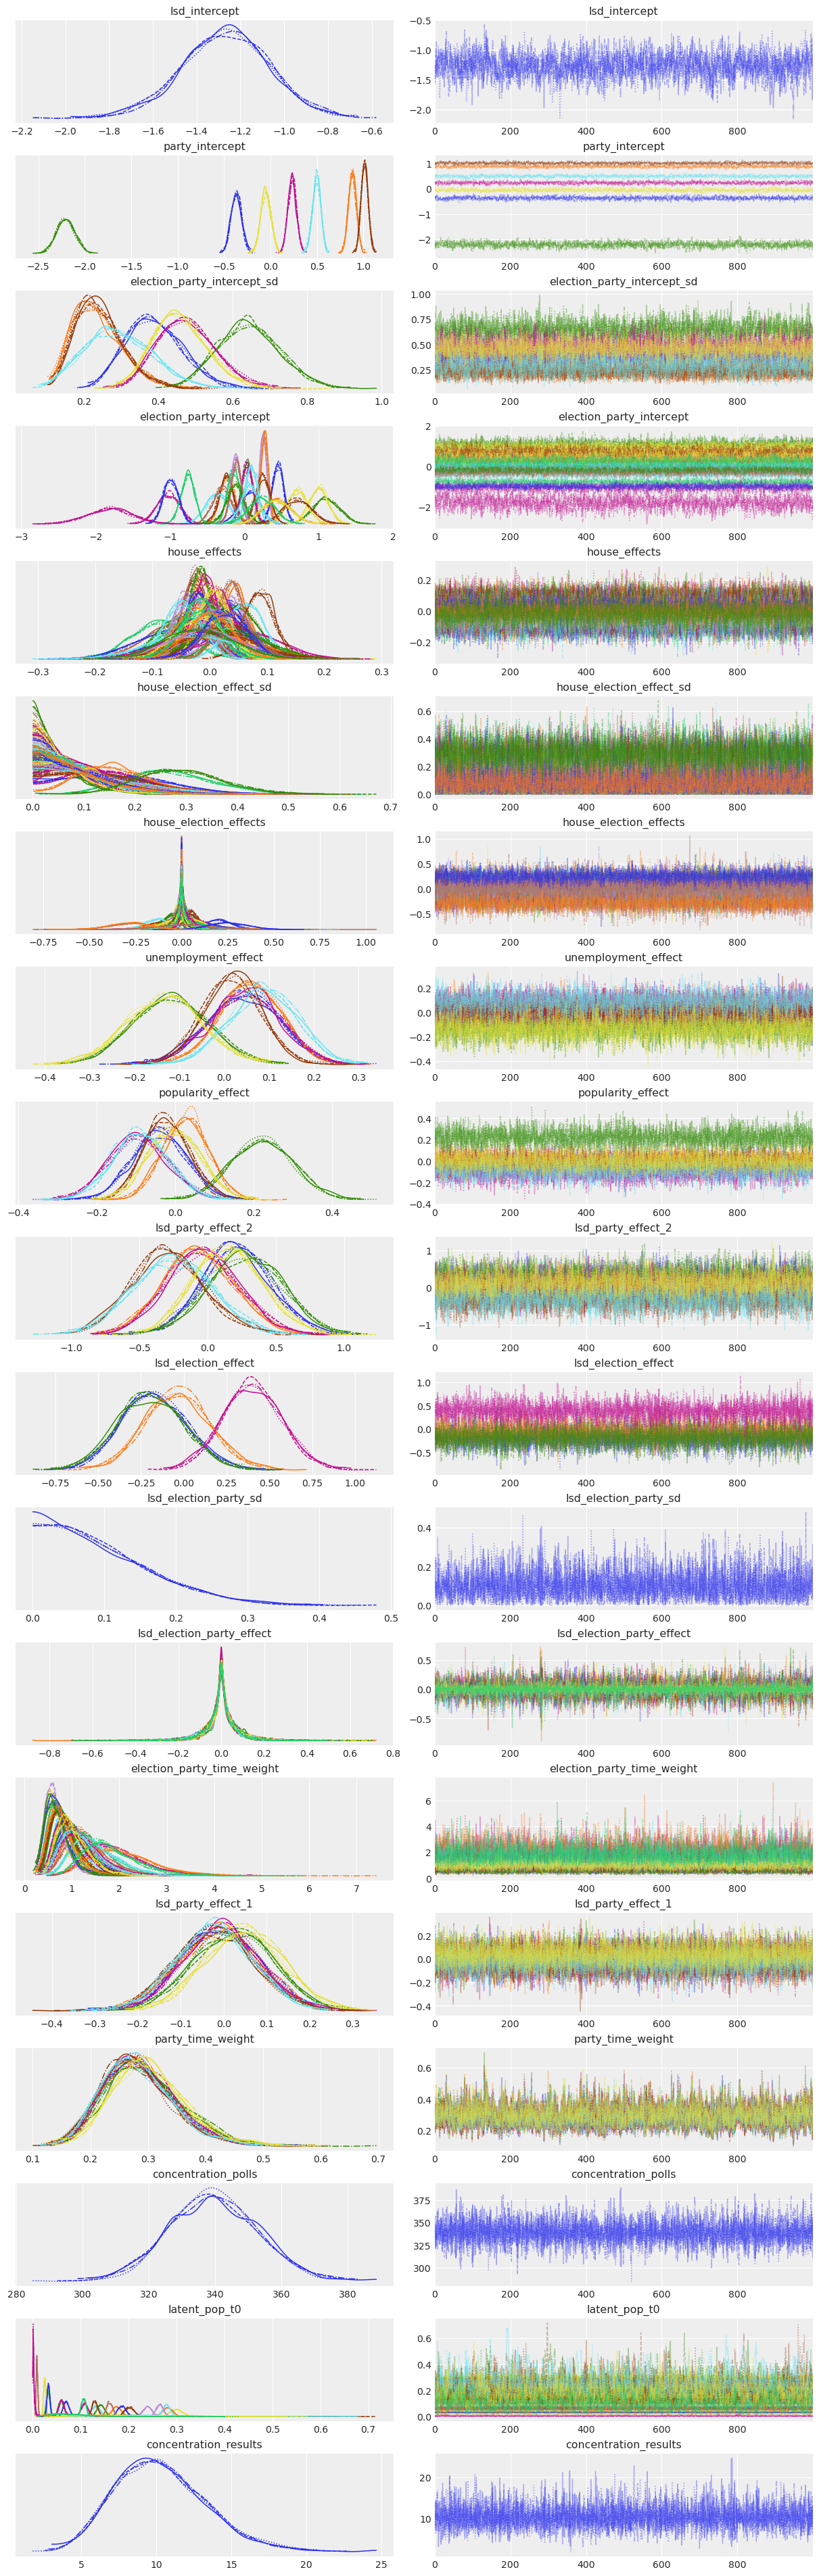

In [130]:
arviz.plot_trace(
    idata_hierarchical_dm,
    var_names=[
        "~time_effect",
        "~time_coefs",
        "~latent_popularity",
        "~noisy_popularity",
        "~raw",
    ],
    filter_vars="regex",
);

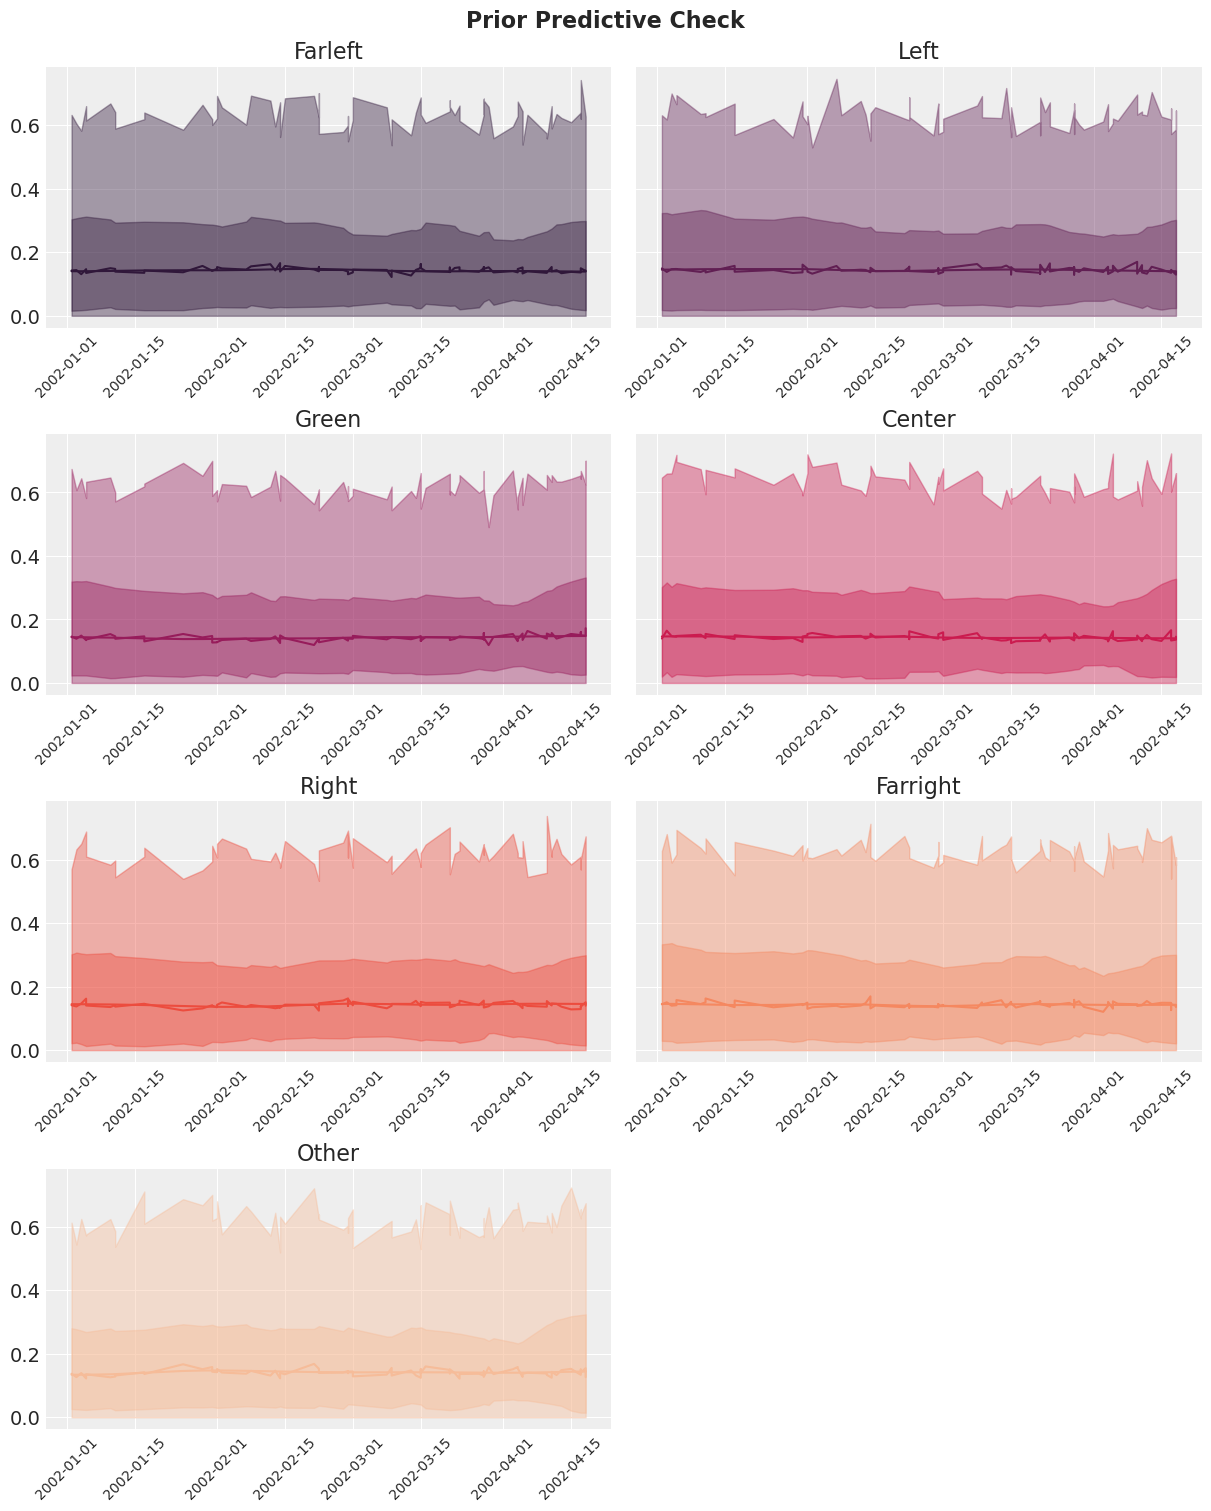

In [63]:
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections="2002-04-21",
        observations=polls_train[polls_train.dateelection == "2002-04-21"].index,
    ),
    PARTIES_COMPLETE,
    polls_train[polls_train.dateelection == "2002-04-21"],
    group="prior",
)

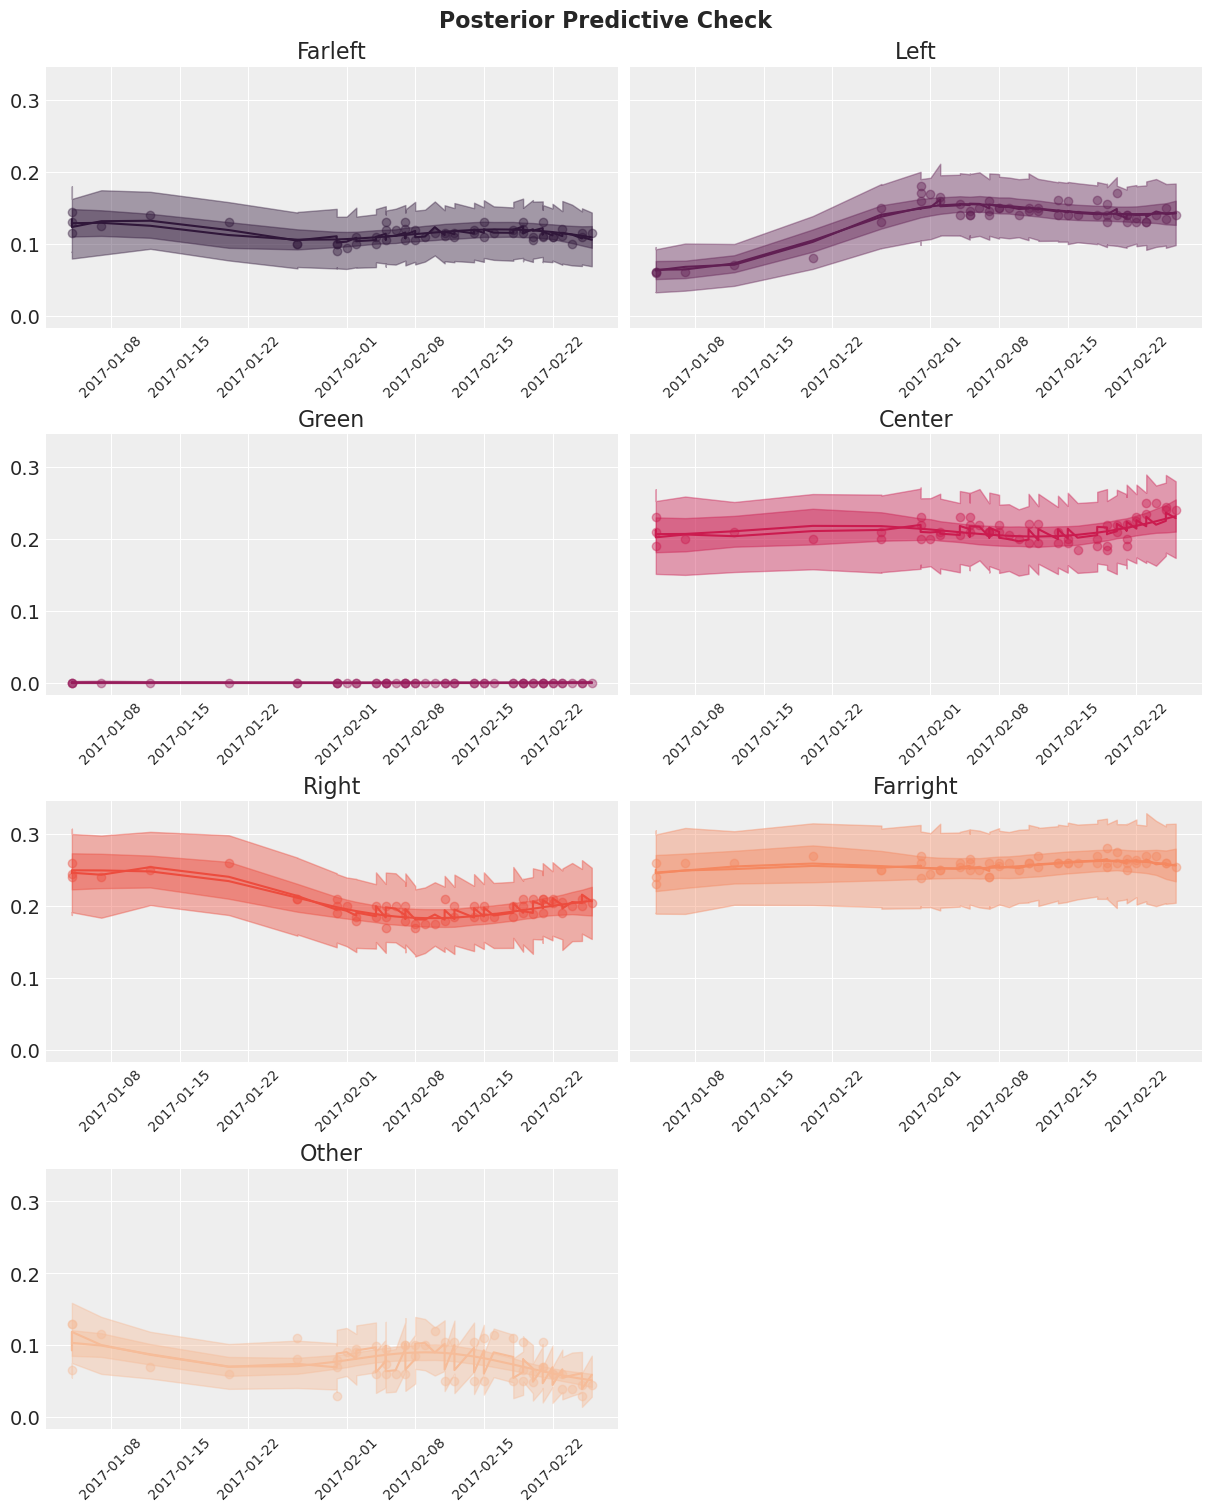

In [131]:
election_date = "2017-04-23"
retrodictive_plot(
    idata_hierarchical_dm.sel(
        elections=election_date,
        observations=polls_train[polls_train.dateelection == election_date].index,
    ),
    PARTIES_COMPLETE,
    polls_train[polls_train.dateelection == election_date],
    group="posterior",
)

In [43]:
def forecast_election(
    idata,
):
    countdown = idata.posterior["countdown"]  # [1:]
    elections = idata.posterior["elections"]

    estimated_days = np.tile(countdown[::-1], reps=len(elections))
    N_estimated_days = len(estimated_days)

    new_dates = []
    for date in elections.data:
        new_dates.append(
            pd.date_range(
                periods=max(countdown.data) + 1,
                end=date,
                freq="D",  # closed="left"
            ).to_series()
        )
    new_dates = pd.concat(new_dates).index

    oos_data = pd.DataFrame.from_dict(
        {
            "countdown": estimated_days,
            "dateelection": np.repeat(UNIQUE_ELECTIONS, repeats=len(countdown)),
            "sondage": np.random.choice(UNIQUE_POLLSTERS, size=N_estimated_days),
            "samplesize": np.random.choice(
                polls_train["samplesize"].values, size=N_estimated_days
            ),
        }
    )
    oos_data["date"] = new_dates
    oos_data = oos_data.set_index("date")

    # join with predictors
    oos_data["quarter"] = oos_data.index.to_period("Q")
    oos_data["month"] = oos_data.index.to_period("M")

    oos_data = oos_data.join(unemp, on="quarter").join(popularity, on="month")
    np.testing.assert_allclose(0, oos_data.isna().any().mean())

    # stdz predictors based on observed values
    oos_data["unemployment"] = (
        oos_data["unemployment"] - cont_preds["unemployment"].mean()
    ) / cont_preds["unemployment"].std()
    oos_data["mean_pop"] = (
        oos_data["mean_pop"] - cont_preds["mean_pop"].mean()
    ) / cont_preds["mean_pop"].std()

    oos_data = oos_data.reset_index()

    forecast_data_index = pd.DataFrame(
        data=0,  # just a placeholder
        index=pd.MultiIndex.from_frame(oos_data),
        columns=PARTIES_COMPLETE,
    )
    forecast_data = forecast_data_index.reset_index()

    PREDICTION_COORDS = {"observations": new_dates}
    PREDICTION_DIMS = {
        "latent_popularity": ["observations", "parties_complete"],
        "noisy_popularity": ["observations", "parties_complete"],
        "N_approve": ["observations", "parties_complete"],
    }

    forecast_model = model_factory(
        {
            "polls_train": forecast_data,
            "campaign_preds": forecast_data,
            "results_oos": results_oos,
            "results_preds": results_preds,
        },
        PARTIES_COMPLETE,
    )
    with forecast_model:
        ppc = pm.sample_posterior_predictive(
            idata,
            var_names=[
                "latent_popularity",
                "noisy_popularity",
                "N_approve",
            ],
        )
        ppc = arviz.from_pymc3_predictions(
            ppc,
            idata_orig=idata,
            inplace=False,
            coords=PREDICTION_COORDS,
            dims=PREDICTION_DIMS,
        )

    return ppc

In [132]:
election_forecast = forecast_election(idata_hierarchical_dm)

In [59]:
polls_train.dateelection.unique()

array(['2002-04-21T00:00:00.000000000', '2007-04-22T00:00:00.000000000',
       '2012-04-22T00:00:00.000000000', '2017-04-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

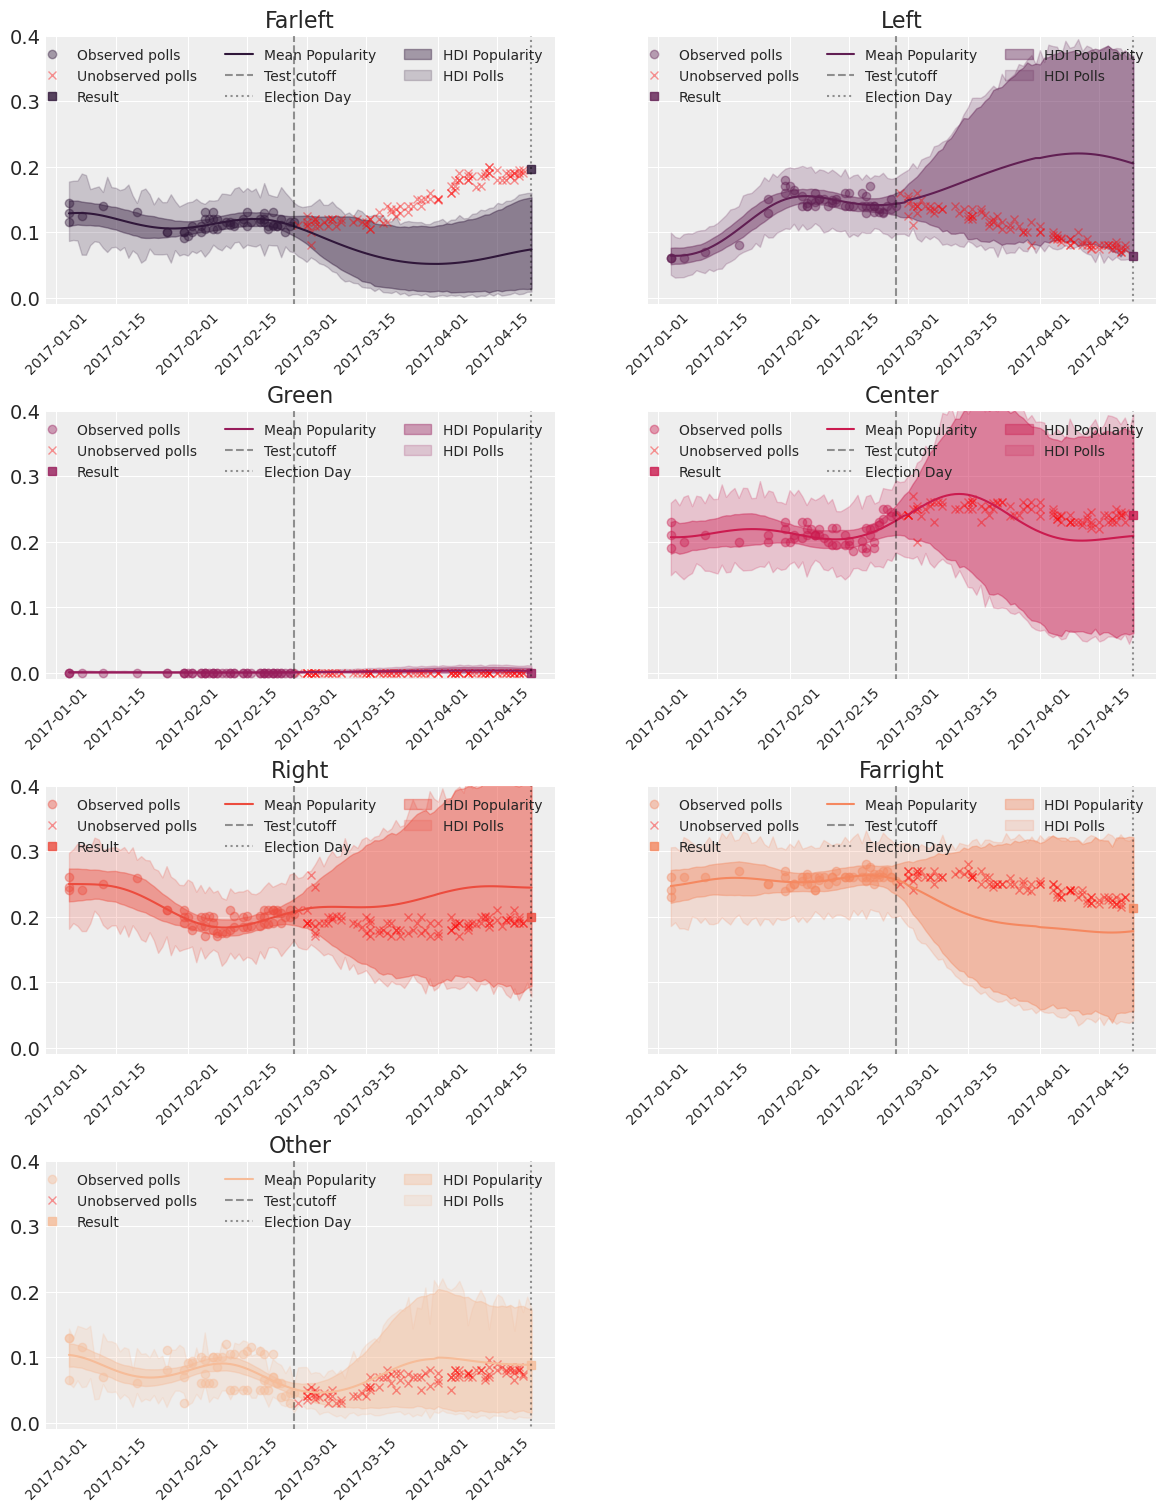

In [133]:
election_date = "2017-04-23"
predictive_plot(
    election_forecast,
    PARTIES_COMPLETE,
    election_date,
    results[results.dateelection == election_date],
    polls_train[polls_train.dateelection == election_date],
    polls_test[polls_test.dateelection == election_date],
    TEST_CUTOFF
)
plt.savefig("ppc.png")

In [ ]:
# better priors (i.e lower/upper bounds, and make sure party=0 when not there)
# covarying GP (transition matrix)

In [ ]:
# https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm
# add other election types (https://github.com/pollsposition/models/blob/master/district-level/munic_model_prod.ipynb)